In [37]:
%pip install -e git+https://github.com/cldf-datasets/wals.git@v2020#egg=cldfbench_wals --quiet

Note: you may need to restart the kernel to use updated packages.


In [38]:
from cldfbench import get_dataset
import pandas as pd
import numpy as np
from IPython.display import display
from conlanger.utils import display_rows

In [39]:
wals = get_dataset("wals").cldf_reader()

In [40]:
lang_df = pd.DataFrame(wals.iter_rows("LanguageTable"))[["ID", "Name", "ISO639P3code"]]
display(lang_df.head(3))
lang_df.shape

,ID,Name,ISO639P3code
0,aab,Arapesh (Abu),None
1,aar,Aari,aiw
2,aba,Abau,aau


(2662, 3)

In [41]:
param_df = (
    pd.DataFrame(wals.iter_rows("ParameterTable"))
    .set_index(["Area", "Chapter"])
    .drop(columns=["Description", "Contributor_ID"])
)

param_df = param_df[
    ~param_df.index.get_level_values("Area").isin(["Sign Languages", "Other"])
]

areas = param_df.index.unique(level="Area")
chapters = param_df.index.unique(level="Chapter")

print(f"Areas: {areas.shape[0]}")
print(f"Chapters: {chapters.shape[0]}")
print(f"Parameters: {param_df.shape[0]}")

parameters = param_df[["ID", "Name"]].to_numpy()

param_df.groupby(level=[0]).head(2)

Areas: 9
Chapters: 140
Parameters: 188


ID  \
Area               Chapter                                                
Phonology          Consonant Inventories                             1A   
                   Vowel Quality Inventories                         2A   
Morphology         Fusion of Selected Inflectional Formatives       20A   
                   Exponence of Selected Inflectional Formatives    21A   
Nominal Categories Number of Genders                                30A   
                   Sex-based and Non-sex-based Gender Systems       31A   
Nominal Syntax     Obligatory Possessive Inflection                 58A   
                   Obligatory Possessive Inflection                 58B   
Verbal Categories  Perfective/Imperfective Aspect                   65A   
                   The Past Tense                                   66A   
Word Order         Order of Subject, Object and Verb                81A   
                   Order of Subject, Object and Verb                81B   
Simple Clauses     Alignment of Case Marking of Full Noun Phrases   98A   
                   Alignment of Case Marking of Pronouns            99A   
Complex Sentences  Relativization on Subjects                      122A   
                   Relativization on Obliques                      123A   
Lexicon            Hand and Arm                                    129A   
                   Finger and Hand                                 130A   

                                                                                                                Name  
Area               Chapter                                                                                            
Phonology          Consonant Inventories                                                       Consonant Inventories  
                   Vowel Quality Inventories                                               Vowel Quality Inventories  
Morphology         Fusion of Selected Inflectional Formatives             Fusion of Selected Inflectional Formatives  
                   Exponence of Selected Inflectional Formatives       Exponence of Selected Inflectional Formatives  
Nominal Categories Number of Genders                                                               Number of Genders  
                   Sex-based and Non-sex-based Gender Systems             Sex-based and Non-sex-based Gender Systems  
Nominal Syntax     Obligatory Possessive Inflection                                 Obligatory Possessive Inflection  
                   Obligatory Possessive Inflection                                       Number of Possessive Nouns  
Verbal Categories  Perfective/Imperfective Aspect                                     Perfective/Imperfective Aspect  
                   The Past Tense                                                                     The Past Tense  
Word Order         Order of Subject, Object and Verb                               Order of Subject, Object and Verb  
                   Order of Subject, Object and Verb               Languages with two Dominant Orders of Subject,...  
Simple Clauses     Alignment of Case Marking of Full Noun Phrases     Alignment of Case Marking of Full Noun Phrases  
                   Alignment of Case Marking of Pronouns                       Alignment of Case Marking of Pronouns  
Complex Sentences  Relativization on Subjects                                             Relativization on Subjects  
                   Relativization on Obliques                                             Relativization on Obliques  
Lexicon            Hand and Arm                                                                         Hand and Arm  
                   Finger and Hand                                                                   Finger and Hand

In [42]:
code_df = pd.DataFrame(wals.iter_rows("CodeTable"))
code_df.head(3)

,ID,Parameter_ID,Name,Description,Number,icon
0,1A-1,1A,Small,Small,1,c0000dd
1,1A-2,1A,Moderately small,Moderately small,2,c9999ff
2,1A-3,1A,Average,Average,3,cffffff


In [43]:
value_df = (
    pd.DataFrame(wals.iter_rows("ValueTable"))
    .drop(columns=["ID", "Code_ID", "Comment", "Source", "Example_ID"])
    .merge(
        lang_df[["ID", "Name"]].rename(columns={"Name": "Language_Name"}),
        left_on="Language_ID",
        right_on="ID",
    )
)
value_df["Value"] = value_df["Value"].astype(int)
value_df["Language_Name"] = value_df["Language_Name"].str.split(" (", regex=False).str[0]

value_df.head(3)

,Language_ID,Parameter_ID,Value,ID,Language_Name
0,aab,81A,2,aab,Arapesh
1,aab,82A,1,aab,Arapesh
2,aab,83A,2,aab,Arapesh


In [44]:
example_df = pd.DataFrame(wals.iter_rows("ExampleTable"))
example_df.head(3)

,ID,Language_ID,Primary_Text,Analyzed_Word,Gloss,Translated_Text,Meta_Language_ID,Comment
0,igt-1,mnd,tāmen tōu zìxíngchē,"[tāmen, tōu, zìxíngchē]","[3PL, steal, bicycle]",They steal bicycles.,None,None
1,igt-2,mnd,[wǒ gěi nǐ de] shū,"[[wǒ, gěi, nǐ, de], shū]","[[1SG, give, 2SG, LINK], book]",the book [that I gave you],None,None
2,igt-3,nbd,dımın ıdw ṍww(ı),"[dımın, ıdw, ṍww(ı)]","[ten, eight, two]",82,None,None


In [48]:
def map_params(df):
    lang = df.to_numpy()
    lang_value_indices = np.isin(lang[:, 0], parameters[:, 0]).nonzero()
    param_indices = np.isin(parameters[:, 0], lang[:, 0]).nonzero()
    result = np.zeros(parameters[:, 0].shape)
    result[param_indices] = lang[:, 1][lang_value_indices]
    return result


values_by_language = value_df.groupby(["Language_ID", "Language_Name"])
unique_languages = np.array([[id, name] for (id, name), group in values_by_language])

language_parameters = np.hstack(
    [
        np.stack(
            values_by_language.apply(map_params, include_groups=False).to_numpy()
        ).astype(int),
        np.zeros((unique_languages.shape[0], 4)),
    ]
)

# remove languages with no parameter values ("Sign Languages", "Other")
mask = np.sum(language_parameters, axis=1) > 1

unique_languages = unique_languages[mask]
language_parameters = language_parameters[mask].reshape(
    unique_languages.shape[0], 12, -1
)

language_parameters.shape, unique_languages.shape, parameters.shape

((2527, 12, 16), (2527, 2), (188, 2))

In [49]:
np.savez_compressed(
    "./data/language_parameters.npz",
    language_parameters=language_parameters,
    languages=unique_languages,
    parameters=parameters,
)

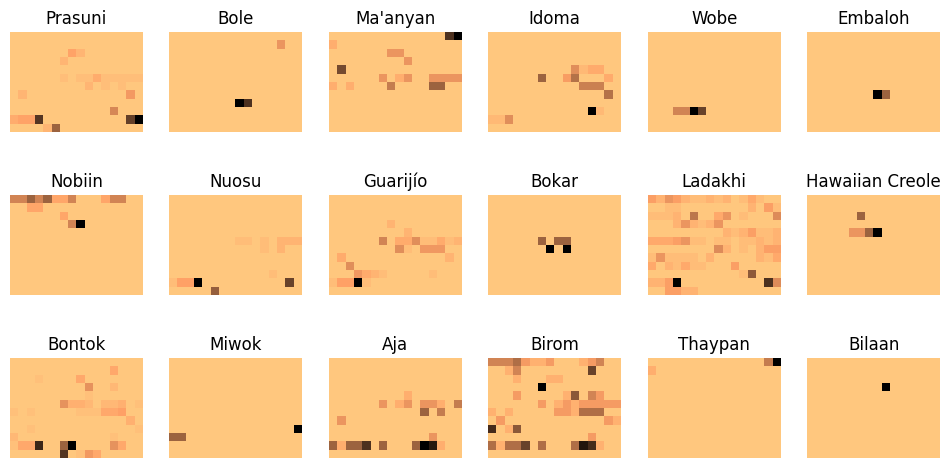

In [50]:
import matplotlib.pyplot as plt

r, c = 3, 6

gen = np.random.default_rng()
sample_indices = gen.choice(unique_languages.shape[0], r * c, replace=False)
samples = language_parameters[sample_indices]
sample_names = unique_languages[:, 1][sample_indices]

display_rows(samples, titles=sample_names, cmap="copper_r", r=r, c=c, size=(12, 6))